In [134]:
!pip install pandas
!pip install numpy
!pip install scikit-learn
!pip install seaborn
!pip install mlxtend
!pip install matplotlib
!pip install shap

   ---------------------------------------- 0.0/99.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/99.8 MB 1.3 MB/s eta 0:01:18
   ---------------------------------------- 0.0/99.8 MB 1.3 MB/s eta 0:01:18
   ---------------------------------------- 0.1/99.8 MB 762.6 kB/s eta 0:02:11
   ---------------------------------------- 0.1/99.8 MB 901.1 kB/s eta 0:01:51
   ---------------------------------------- 0.2/99.8 MB 952.6 kB/s eta 0:01:45
   ---------------------------------------- 0.2/99.8 MB 1.2 MB/s eta 0:01:26
   ---------------------------------------- 0.3/99.8 MB 1.2 MB/s eta 0:01:24
   ---------------------------------------- 0.4/99.8 MB 1.2 MB/s eta 0:01:21
   ---------------------------------------- 0.4/99.8 MB 1.3 MB/s eta 0:01:20
   ---------------------------------------- 0.6/99.8 MB 1.7 MB/s eta 0:01:00
   ---------------------------------------- 0.8/99.8 MB 1.9 MB/s eta 0:00:53
   ---------------------------------------- 1.1/99.8 MB 2.4 MB/s eta 0:00:41


In [152]:
import pandas as pd
import numpy as np
import seaborn as sns
import shap
from mlxtend.classifier import OneRClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, roc_curve, auc, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [153]:
# Получить очищенные X, y train
def get_clean_X_y(dataset_url):
    #Загружаем dataset
    df = pd.read_csv(dataset_url)

    # Очищаем строки с пропущенными значениями
    df = df.dropna()

    # Удаляем дубли
    df = df.drop_duplicates()

    # Удаляем лишний столбец
    df.drop('Unnamed: 0', axis=1, inplace=True)

    # Признаки
    column_list = df.columns.values.tolist()

    # Целевая переменная - satisfaction (y)
    satisfaction = df['satisfaction']

    column_list.remove('satisfaction')

    # Анализируемые признаки (X)
    df_analyzed = df[column_list]

    return df_analyzed, satisfaction

    

In [154]:
# Установка категорий удовлетворенности (0, 1)
def get_categories_for_satisfaction(series):
    arr = series.values
    arr_temp = []
    borders = ['neutral or dissatisfied', 'satisfied']
    
    for i in range(0, len(arr)):
        for j in range(0, len(borders)):
            if (arr[i] == borders[j]):
                arr_temp.append(j)
                break

    return pd.Series(arr_temp)

In [155]:
# Установить интервал для признака (4 интервала);
def set_interval_for_feature(df: pd.DataFrame, feature: str):
    values = df[feature].to_numpy()
    min_value = np.min(values)
    max_value = np.max(values)
    interval_value = (max_value - min_value) / 4
    categories = np.arange(min_value, min_value + (5 * interval_value), interval_value)
    categories = categories[1:]
    arr = df[feature].values
    arr_temp = []
    for i in range(0, len(arr)):
        for j in range(0, len(categories)):
            if (arr[i] <= categories[j]):
                arr_temp.append(j)
                break

    df[f'{feature} categories'] = arr_temp
    df.drop(feature, axis=1, inplace=True)

In [156]:
# Установить категорию для признака, где значения бинарные (0, 1);
def set_category_for_feature(df: pd.DataFrame, feature: str):
    values = df[feature].to_numpy()
    unique_values = np.unique(values)
    arr = df[feature].values
    arr_temp = []
    for i in range(0, len(arr)):
        for j in range(0, len(unique_values)):
            if arr[i] == unique_values[j]:
                arr_temp.append(j)
                break

    df[f'{feature} categories'] = arr_temp
    df.drop(feature, axis=1, inplace=True)

In [157]:
def set_interval_for_features(df, features):
    for feature in features:
        set_interval_for_feature(df, feature)

In [158]:
def set_categories_for_features(df, features):
    for feature in features:
        set_category_for_feature(df, feature)

In [159]:
# Установить ранги для признака "Class" (0, 1, 2);
def set_range_for_class_feature(df: pd.DataFrame):
    classes = ['Eco', 'Eco Plus', 'Business']
    arr = df['Class'].values
    arr_temp = []
    for i in range(0, len(arr)):
        for j in range(0, len(classes)):
            if arr[i] == classes[j]:
                arr_temp.append(j)
                break

    df['Class categories'] = arr_temp
    df.drop('Class', axis=1, inplace=True)

In [160]:
# Заполнить предикторы
def fill_X(df):
    set_interval_for_features(df, ['Age', 'Arrival Delay in Minutes', 'Departure Delay in Minutes', 'Flight Distance'])
    set_categories_for_features(df, ['Gender', 'Customer Type', 'Type of Travel'])
    set_range_for_class_feature(df)
    df.drop('id', axis=1, inplace=True)
    df = df.astype('int64', copy=True)

In [161]:
# Заполнить целевую переменную
def fill_Y(df):
    return get_categories_for_satisfaction(df)


In [162]:
def get_dfs():
    # Получаем предобработанные данные
    X_train, y_train = get_clean_X_y('train.csv')
    X_test, y_test = get_clean_X_y('test.csv')

    # Обрабатываем данные для классификации
    fill_X(X_train)
    fill_X(X_test)
    y_train = fill_Y(y_train)
    y_test = fill_Y(y_test)

    return X_train, y_train, X_test, y_test 

In [163]:
# График матрицы ошибок
def print_confusion_matrix(model, X_test, y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    ConfusionMatrixDisplay.from_estimator(model, X_test, y_test)

In [164]:
# График ROC AUC
def print_roc_auc_curve(model, X_test, y_test, y_pred):
    if not hasattr(model, 'predict_proba'):
        return
        
    y_pred_proba = model.predict_proba(X_test)[::,1]
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    auc = roc_auc_score(y_test, y_pred_proba)
    
    plt.plot (fpr,tpr,label=" AUC= " + str(auc))
    plt.legend(loc=4)
    plt.show()

In [165]:
# Получить основные матрики accuracy, f1, auc
def get_common_metrics(model, y_test, y_pred, X_test):
    accuracy = None
    f1 = None
    auc = None
    
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    if hasattr(model, 'predict_proba'):
        auc = roc_auc_score(y_test, model.predict_proba(X_test)[:,1])

    result = {
        'accuracy': accuracy,
        'f1': f1,
        'auc': auc,
    }

    return result

In [166]:
# Отобразить метрики
def print_metrics(model, model_name, X_test, y_test, y_pred):
    # Оценка качества модели на тестовых данных (датасет df)
    print(f'--- {model_name} ---')
    metrics = get_common_metrics(model, y_test, y_pred, X_test)
    print("Accuracy: {:.5f}".format(metrics['accuracy']))
    print("F1: {:.5f}".format(metrics['f1']))
    
    if hasattr(model, 'predict_proba'):
        print("ROC AUC: {:.5f}".format(metrics['auc']))

    print('-------')

    print_roc_auc_curve(model, X_test, y_test, y_pred)
    print_confusion_matrix(model, X_test, y_test, y_pred)

In [167]:
# Получить основной график shap
def get_summary_shap(model, X_train: pd.DataFrame, y_train: pd.Series, X_test: pd.DataFrame):
    explainer = shap.TreeExplainer(model.fit(X_train, y_train))
    shap_values = explainer.shap_values(X_test)
    shap.summary_plot(shap_values, X_test)

In [168]:
# Получить график переменных влияющих на прогноз
def get_waterfall_shap(model, X_train: pd.DataFrame, y_train: pd.Series, X_test: pd.DataFrame):
    explainer = shap.Explainer(model, X_train)
    shap_values = explainer(X_test)
    explanation = shap_values[0]
    shap.plots.waterfall(explanation)

In [169]:
# Классификация OneRule
def classifier_one_rule():
    oner = OneRClassifier()
    
    X_train, y_train, X_test, y_test  = get_dfs()
    
    oner.fit(X_train.values, y_train.values)
    
    print('Индекс признака, по которому идёт классификация: ', oner.feature_idx_)
    print('Соответствие признака и класса: ', oner.prediction_dict_)
    print('Признак по которому классифицируется: ', X_train.columns.tolist()[5])
    
    # Accuracy
    y_pred = oner.predict(X_test.values)
    test_acc = np.mean(y_pred == y_test.values)  
    print(f'Test accuracy {test_acc*100:.2f}%')

In [170]:
classifier_one_rule()

Индекс признака, по которому идёт классификация:  5
Соответствие признака и класса:  {'total error': 21720, 'rules (value: class)': {0: 1, 1: 0, 2: 0, 3: 0, 4: 1, 5: 1}}
Признак по которому классифицируется:  Online boarding
Test accuracy 78.82%


In [178]:
class AllModels(object):
    ensemble_label = 'ensemble';
    
    def __init__(self):
        models = [
            ('LogisticRegression', LogisticRegression(solver='liblinear', penalty = 'l1')),
            ('KNeighborsClassifier', KNeighborsClassifier(n_neighbors=2)),
            ('GaussianNB', GaussianNB()),
            ('DecisionTreeClassifier', DecisionTreeClassifier()),
            ('GradientBoostingClassifier', GradientBoostingClassifier()),
            ('SVC', SVC()),
            ('MLPClassifier', MLPClassifier()),
        ]
        
        self.ensemble = VotingClassifier(estimators=models, voting='hard')

        self.all_models = models

    def fit(self, X_train: pd.DataFrame, y_train: pd.Series, X_test: pd.DataFrame, y_test: pd.Series):
        self.X_train = X_train
        self.y_train = y_train
        self.X_test = X_test
        self.y_test = y_test

        for model in self.all_models:
            model[1].fit(self.X_train.values, self.y_train.values)

        self.ensemble.fit(self.X_train.values, self.y_train.values)

    # Получить названия моделей
    def get_models_name(self):
        model_names = []
        for model in self.all_models:
            model_names.append(model[0])

        print('Models', model_names, self.ensemble_label)
    
    # Получить названия модель
    def get_model(self, model_name: str):
        if (model_name == self.ensemble_label):
            return self.ensemble
        
        for model in self.all_models:
            if model_name == model[0]:
                return model[1]
                
    # Получить метрики модели
    def get_model_metrics(self, model_name: str):
        if (model_name == self.ensemble_label):
            y_pred = self.ensemble.predict(X_test.values)
            return print_metrics(self.ensemble, self.ensemble_label, X_test.values, y_test.values, y_pred)
        
        for model in self.all_models:
            if model_name == model[0]:
                y_pred = model[1].predict(X_test.values)
                print_metrics(model[1], model[0], X_test.values, y_test.values, y_pred)

    # Получить метрики всех моделей
    def get_all_metrics(self):
        def addlabels(x, y, ax):
            for i in range(len(x)):
                ax.text(i, y[i]/2, "{:.3f}".format(y[i]), va='baseline', ha='center', color='#fff', fontsize='large')
        
        all_models_metrics = {}

        for model in self.all_models:
            y_pred = model[1].predict(X_test.values)
            all_models_metrics[model[0]] = get_common_metrics(model[1], y_test.values, y_pred, X_test.values)
        
        figure, axis = plt.subplots(3, 1, figsize=(15, 15))

        metrics = ['accuracy', 'f1', 'auc'] # 

        for ax, metric in zip(axis, metrics):
            model_names = []
            metric_values = []
            
            for model in self.all_models:
                if all_models_metrics[model[0]][metric] == None:
                    continue;
                
                model_names.append(model[0])
                metric_values.append(all_models_metrics[model[0]][metric])

            model_names = np.array(model_names)
            metric_values = np.array(metric_values)

            ax.bar(model_names, metric_values, color='#7f18ba')
            
            addlabels(model_names, metric_values, ax)
            
            ax.set_title(metric)

        plt.tight_layout(pad=1)
        plt.show()

    # Получить графики ROC AUC
    def get_all_roc_auc_plot(self):
        plt.figure(figsize=(20,8))
        
        for model in self.all_models:
            y_pred_proba = None
            if hasattr(model[1], 'predict_proba'):
                y_pred_proba = model[1].predict_proba(self.X_test.values)[::,1]
            else: 
                continue;
                
            fpr, tpr, thresholds = roc_curve(self.y_test.values, y_pred_proba)
            auc_score = auc(fpr, tpr)
    
            plt.plot(fpr, tpr, label='%s (AUC: %0.6f)' % (model[0], auc_score))

        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC')
        plt.legend(loc='lower right')
        plt.show()

    # Получить описание признаков
    def get_feature_explain(self, model_name: str, type: str):
        for model in self.all_models:
            if model_name == model[0]:
                if type == 'summary':
                    get_summary_shap(model[1], self.X_train, self.y_train, self.X_test)
                if type == 'waterfall':
                    get_waterfall_shap(model[1], self.X_train, self.y_train, self.X_test)

In [179]:
all_models = AllModels()

In [180]:
# Данные для классификации
X_train, y_train, X_test, y_test  = get_dfs()

In [ ]:
all_models.fit(X_train, y_train, X_test, y_test)

 97%|=================== | 25120/25893 [00:23<00:00]       

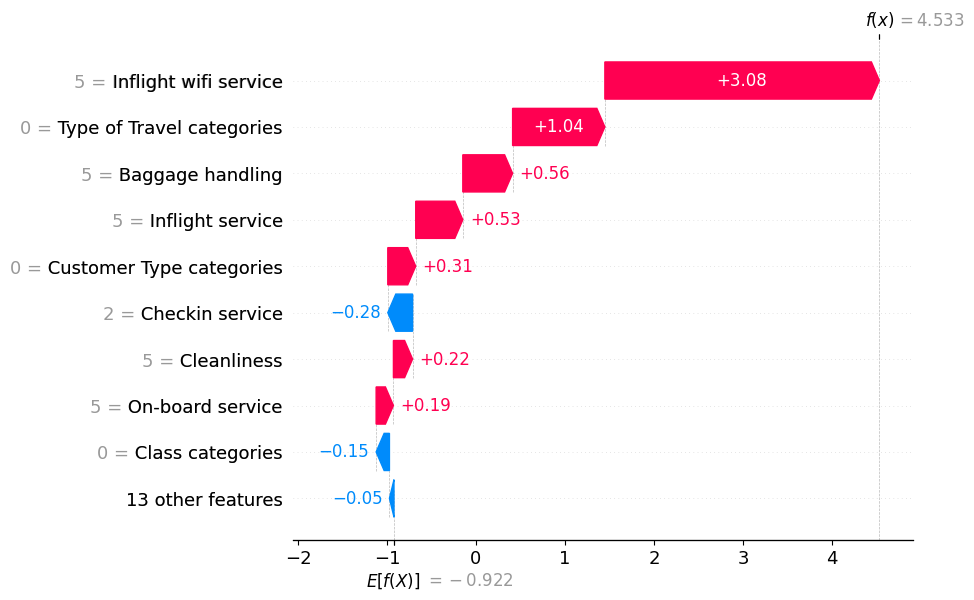

In [116]:
all_models.get_feature_explain('GradientBoostingClassifier', 'waterfall')

In [ ]:
all_models.get_all_metrics()

In [ ]:
all_models.get_all_roc_auc_plot()